This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Load and inspect data from a Rainbow file

In [1]:
import os
import sys
import wradlib as wrl
import matplotlib.pyplot as pl
import numpy as np
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

#### Load Rainbow file

In [2]:
filename = '2014121600001600dBuZ.vol'
wrl_data_path = wrl.util.get_wradlib_data_path()
fpath = os.path.join(wrl_data_path,'rainbow',filename)
rbdict = wrl.io.rainbow.read_rainbow(fpath)
sweep_number = 0
sweep = rbdict['volume']['scan']['slice'][sweep_number]

#### Get azimuthal data

In [3]:
ray = sweep['slicedata']['rayinfo']
try:
    depth = float(ray[0]['@depth'])
    startangle = ray[0]['data']
    startangle = startangle / 2**depth * 360

    depth = float(ray[1]['@depth'])
    stopangle = ray[1]['data']
    stopangle = stopangle / 2**depth * 360

    azi = (startangle + stopangle) / 2
except:
    depth = float(ray['@depth'])
    startangle = ray['data']
    startangle = startangle / 2**depth * 360
    anglestep = float(sweep['anglestep'])
    azi = startangle + anglestep/2


#### Create range array

In [4]:
stoprange = float(sweep['stoprange'])
rangestep = float(sweep['rangestep'])
r = np.arange(0, stoprange, rangestep)
r = r + rangestep/2

#### Get reflectivity data

In [5]:
data = sweep['slicedata']['rawdata']['data']
data = data.astype(float)
decode = True
if decode:
    datadepth = float(sweep['slicedata']['rawdata']['@depth'])
    datamin = float(sweep['slicedata']['rawdata']['@min'])
    datamax = float(sweep['slicedata']['rawdata']['@max'])
    data = datamin + data * (datamax - datamin) / 2 ** datadepth    

#### Get annotation data

In [6]:
unit = sweep['slicedata']['rawdata']['@type']
time = sweep['slicedata']['@time']
date = sweep['slicedata']['@date']
try:
    version = rbdict['volume']['@version']
    lon = rbdict['volume']['sensorinfo']['lon']
    lat = rbdict['volume']['sensorinfo']['lat']
    sensortype = rbdict['volume']['sensorinfo']['@type']
    sensorname = rbdict['volume']['sensorinfo']['@name']
except:    
    lon = rbdict['volume']['radar']['@lon']
    lat = rbdict['volume']['radar']['@lat']    
    version = rbdict['volume']['@version']
    sensorname = rbdict['volume']['radar']['radarname']
    sensortype = "none"

#### Fix CSR

In [7]:
filename2 = None
if filename2 is not None:    
    from wradlib import clutter
    fpath = os.path.join(wrl_data_path,'rainbow',filename2)
    rbdict = wrl.io.rainbow.read_rainbow(fpath)
    sweep = rbdict['volume']['scan']['slice'][0]
    data2 = sweep['slicedata']['rawdata']['data']
    data2 = data2.astype(float)
    dbzh = data
    th = data2
    clutter.fix_csr(dbzh, th, debug=True)

#### Reorgenize data

In [8]:
if np.abs(azi[-1] - azi[0]) < 0.1:
    print("removing double ray")
    azi = azi[1:]
    data = data[1:,:]    
idx = np.argsort(azi)
azi = azi[idx]
data = data[idx,:]
azi = np.round(azi,1)
azi = np.linspace(0.5,359.5,360)


removing double ray


#### Slice data

In [9]:
slice_r = slice(0,200)
slice_a = slice(0,360)
slice_ar = (slice_a, slice_r)
r=r[slice_r]
azi=azi[slice_a]
data = data[slice_ar]
print(azi.shape)
print(data.shape)
print(azi)

(360,)
(360, 200)
[  0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5
  12.5  13.5  14.5  15.5  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5
  24.5  25.5  26.5  27.5  28.5  29.5  30.5  31.5  32.5  33.5  34.5  35.5
  36.5  37.5  38.5  39.5  40.5  41.5  42.5  43.5  44.5  45.5  46.5  47.5
  48.5  49.5  50.5  51.5  52.5  53.5  54.5  55.5  56.5  57.5  58.5  59.5
  60.5  61.5  62.5  63.5  64.5  65.5  66.5  67.5  68.5  69.5  70.5  71.5
  72.5  73.5  74.5  75.5  76.5  77.5  78.5  79.5  80.5  81.5  82.5  83.5
  84.5  85.5  86.5  87.5  88.5  89.5  90.5  91.5  92.5  93.5  94.5  95.5
  96.5  97.5  98.5  99.5 100.5 101.5 102.5 103.5 104.5 105.5 106.5 107.5
 108.5 109.5 110.5 111.5 112.5 113.5 114.5 115.5 116.5 117.5 118.5 119.5
 120.5 121.5 122.5 123.5 124.5 125.5 126.5 127.5 128.5 129.5 130.5 131.5
 132.5 133.5 134.5 135.5 136.5 137.5 138.5 139.5 140.5 141.5 142.5 143.5
 144.5 145.5 146.5 147.5 148.5 149.5 150.5 151.5 152.5 153.5 154.5 155.5
 156.5 157.5 158.5 159.5 160.5 16

#### Plot data with annotation

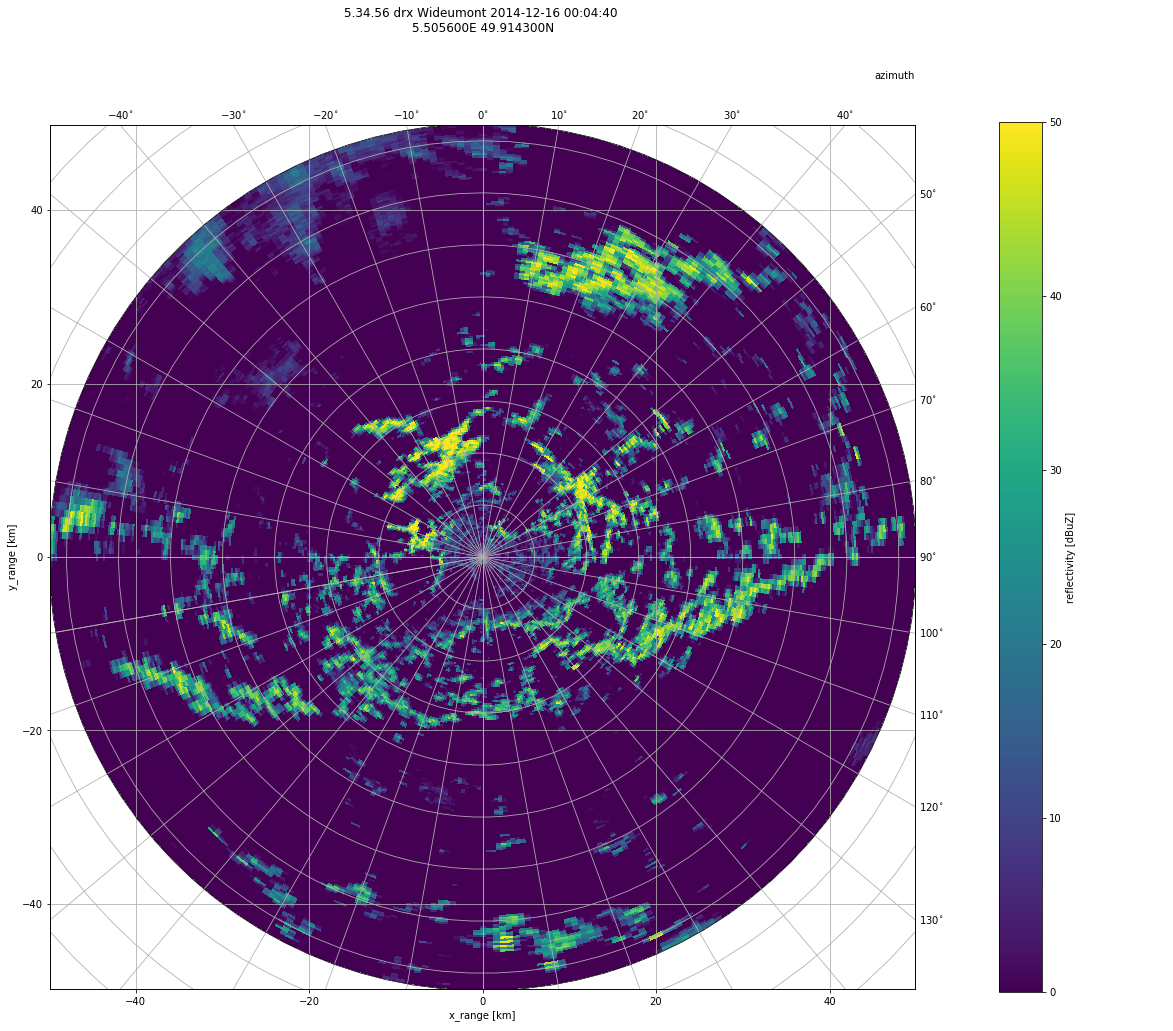

In [10]:
fig = pl.figure(figsize=(20,16))
cgax, pm = wrl.vis.plot_ppi(data, r=r, az=azi, fig=fig, proj='cg', vmin=0, vmax=50)



title = '{0} {1} {2} {3} {4} \n{5}E {6}N'.format(version, sensortype, sensorname, date,
                                            time, lon, lat)
caax = cgax.parasites[0]
t = pl.title(title, fontsize=12)
t.set_y(1.1)
cbar = pl.gcf().colorbar(pm, pad=0.075)
caax.set_xlabel('x_range [km]')
caax.set_ylabel('y_range [km]')
pl.text(1.0, 1.05, 'azimuth', transform=caax.transAxes, va='bottom',
        ha='right')
cbar.set_label('reflectivity [' + unit + ']')
filename = filename.replace('vol','png')
outdir=os.environ["HOME"]
fpath=os.path.join(outdir,filename)
pl.savefig(fpath)